# Visual Question Answering (Classification)

In [1]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import   AutoModel, AutoFeatureExtractor, AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import logging

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [3]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda:0
Tesla T4


# Dataset

In [5]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset","data_train.csv"),
        "test": os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset", "data_eval.csv")
    }
)

with open(os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c23e0d19ce5241c8/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

In [6]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

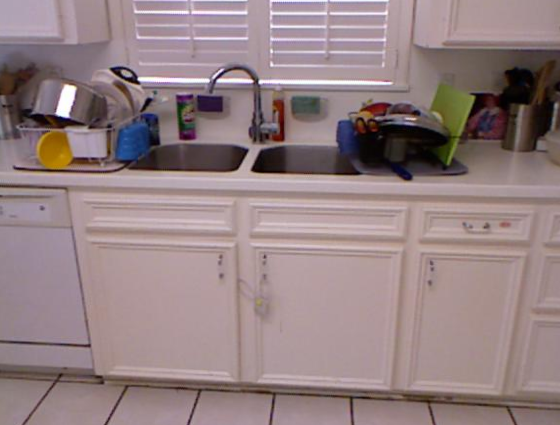

Question:	 what is the light green colour object found in the kitchen utensils
Answer:		 cutting_board (Label: 151)


In [7]:
showExample()

## Multimodal Collator

returns text and image modalities

In [8]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

## Multimodal VQA Model Architecture

In [9]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):
     
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

### Define a Function to Create the Multimodal VQA Models along with their Collators

In [10]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

## Performance Metrics 

In [11]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

In [12]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [13]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['tray', 'toys_rack', 'scale', 'furniture', 'spice_stand']
['frying_pan', '11', 'oven', 'light_switch', 'black']
Predictions vs Labels:  0.02095238095238095
Labels vs Labels:  1.0


In [14]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

## Model Training & Evaluation

In [15]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training 
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16=True,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [16]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("..", "checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()
    
    return collator, model, train_multi_metrics, eval_multi_metrics

In [16]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Using amp half precision backend
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9974
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulat

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 5.734, 'learning_rate': 4.67948717948718e-05, 'epoch': 0.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.945195198059082, 'eval_wups': 0.16130200528683053, 'eval_acc': 0.10344827586206896, 'eval_f1': 0.0030120413078513243, 'eval_runtime': 33.9531, 'eval_samples_per_second': 73.454, 'eval_steps_per_second': 2.297, 'epoch': 0.32}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 4.9005, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.587068557739258, 'eval_wups': 0.1627845290680753, 'eval_acc': 0.10505212510024058, 'eval_f1': 0.0029796402753703762, 'eval_runtime': 35.0966, 'eval_samples_per_second': 71.061, 'eval_steps_per_second': 2.222, 'epoch': 0.64}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 4.6484, 'learning_rate': 4.038461538461539e-05, 'epoch': 0.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.373326301574707, 'eval_wups': 0.18291848427263127, 'eval_acc': 0.12590216519647154, 'eval_f1': 0.005600057250086657, 'eval_runtime': 32.3311, 'eval_samples_per_second': 77.139, 'eval_steps_per_second': 2.413, 'epoch': 0.96}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 4.3832, 'learning_rate': 3.7211538461538466e-05, 'epoch': 1.28}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.21221399307251, 'eval_wups': 0.2084310463760804, 'eval_acc': 0.1495589414595028, 'eval_f1': 0.00704809518921624, 'eval_runtime': 30.262, 'eval_samples_per_second': 82.414, 'eval_steps_per_second': 2.577, 'epoch': 1.28}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-100] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 4.2994, 'learning_rate': 3.400641025641026e-05, 'epoch': 1.6}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.106414318084717, 'eval_wups': 0.2018465564539082, 'eval_acc': 0.14995990376904572, 'eval_f1': 0.008234200634700381, 'eval_runtime': 27.9881, 'eval_samples_per_second': 89.109, 'eval_steps_per_second': 2.787, 'epoch': 1.6}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-200] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 4.1443, 'learning_rate': 3.0801282051282055e-05, 'epoch': 1.92}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.027106285095215, 'eval_wups': 0.2432410482612174, 'eval_acc': 0.1768243785084202, 'eval_f1': 0.011061960976093535, 'eval_runtime': 30.804, 'eval_samples_per_second': 80.963, 'eval_steps_per_second': 2.532, 'epoch': 1.92}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-300] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 4.009, 'learning_rate': 2.759615384615385e-05, 'epoch': 2.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9412264823913574, 'eval_wups': 0.23621510926447337, 'eval_acc': 0.1760224538893344, 'eval_f1': 0.01023043721722833, 'eval_runtime': 31.1991, 'eval_samples_per_second': 79.938, 'eval_steps_per_second': 2.5, 'epoch': 2.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-400] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 3.9533, 'learning_rate': 2.4391025641025643e-05, 'epoch': 2.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8712902069091797, 'eval_wups': 0.2363884579891014, 'eval_acc': 0.17963111467522053, 'eval_f1': 0.01197050731199774, 'eval_runtime': 30.8711, 'eval_samples_per_second': 80.787, 'eval_steps_per_second': 2.527, 'epoch': 2.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-500] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 3.9053, 'learning_rate': 2.1185897435897437e-05, 'epoch': 2.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.821504831314087, 'eval_wups': 0.25185460057831993, 'eval_acc': 0.19647153167602247, 'eval_f1': 0.014442314174494578, 'eval_runtime': 30.0843, 'eval_samples_per_second': 82.9, 'eval_steps_per_second': 2.593, 'epoch': 2.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-600] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 3.8049, 'learning_rate': 1.798076923076923e-05, 'epoch': 3.21}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.7660670280456543, 'eval_wups': 0.26619644735651554, 'eval_acc': 0.21531676022453888, 'eval_f1': 0.01643661532695236, 'eval_runtime': 29.9896, 'eval_samples_per_second': 83.162, 'eval_steps_per_second': 2.601, 'epoch': 3.21}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-700] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 3.7425, 'learning_rate': 1.4775641025641027e-05, 'epoch': 3.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.760399103164673, 'eval_wups': 0.26723451803794157, 'eval_acc': 0.2161186848436247, 'eval_f1': 0.017767902521590887, 'eval_runtime': 29.8926, 'eval_samples_per_second': 83.432, 'eval_steps_per_second': 2.609, 'epoch': 3.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-800] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 3.6608, 'learning_rate': 1.1570512820512822e-05, 'epoch': 3.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.7140932083129883, 'eval_wups': 0.2721298663211576, 'eval_acc': 0.22052927024859664, 'eval_f1': 0.018686097655243067, 'eval_runtime': 29.7531, 'eval_samples_per_second': 83.823, 'eval_steps_per_second': 2.622, 'epoch': 3.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-900] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 3.6025, 'learning_rate': 8.365384615384616e-06, 'epoch': 4.17}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.6981348991394043, 'eval_wups': 0.27434145195032317, 'eval_acc': 0.22213311948676825, 'eval_f1': 0.018650319367598697, 'eval_runtime': 30.0963, 'eval_samples_per_second': 82.867, 'eval_steps_per_second': 2.592, 'epoch': 4.17}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1000] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 3.5287, 'learning_rate': 5.16025641025641e-06, 'epoch': 4.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.6853766441345215, 'eval_wups': 0.27763968814288964, 'eval_acc': 0.22654370489174017, 'eval_f1': 0.01903548598786097, 'eval_runtime': 30.5398, 'eval_samples_per_second': 81.664, 'eval_steps_per_second': 2.554, 'epoch': 4.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1100] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'loss': 3.6069, 'learning_rate': 1.955128205128205e-06, 'epoch': 4.81}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.678004503250122, 'eval_wups': 0.2787172634642072, 'eval_acc': 0.22774659182036888, 'eval_f1': 0.020356649188117144, 'eval_runtime': 29.8393, 'eval_samples_per_second': 83.581, 'eval_steps_per_second': 2.614, 'epoch': 4.81}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1200] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ../checkpoint/bert_vit/checkpoint-1500 (score: 0.2787172634642072).
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 2494
  Batch size = 32


{'train_runtime': 1492.9447, 'train_samples_per_second': 33.404, 'train_steps_per_second': 1.045, 'train_loss': 4.106994560437324, 'epoch': 5.0}
{'eval_loss': 3.678004503250122, 'eval_wups': 0.2787172634642072, 'eval_acc': 0.22774659182036888, 'eval_f1': 0.020356649188117144, 'eval_runtime': 29.3283, 'eval_samples_per_second': 85.037, 'eval_steps_per_second': 2.66, 'epoch': 5.0}


## Eval

In [16]:
eval_multi_metrics

{'eval_loss': 2.472404504225012,
 'eval_wups': 0.5984217423622422,
 'eval_acc': 0.5342425243215498,
 'eval_samples_per_second': 85.037,
 'eval_steps_per_second': 2.66,
 'epoch': 10.0}

## Examples of Model Inferencing

### Loading the Model from Checkpoint

In [18]:
model = MultimodalVQAModel()

# We use the checkpoint giving best results
model.load_state_dict(torch.load(os.path.join("..", "checkpoint", "bert_vit", "checkpoint-1500", "pytorch_model.bin")))
model.to(device) 

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [19]:
sample = collator(dataset["test"][2000:2005])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

### Pass the Samples through the Model & inspect the Predictions

In [20]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [21]:
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

array([483, 445, 383, 381, 564])

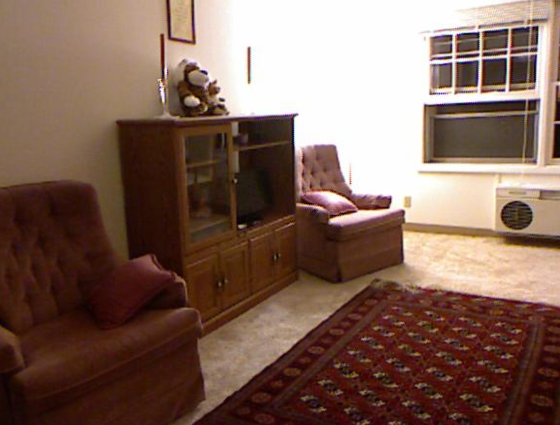

Question:	 what is the most colorful object in this picture
Answer:		 rug (Label: 422)
Predicted Answer:	 rug


In [25]:
showExample(train=False, id=500)
print("Predicted Answer:\t", answer_space[preds[i-2000]])

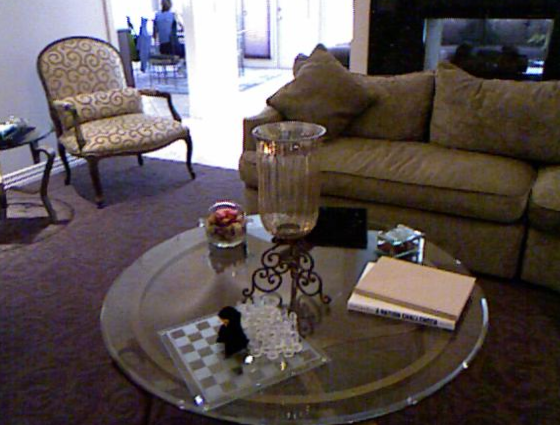

Question:	 what is on the left side of the sofa
Answer:		 chair (Label: 106)
Predicted Answer:	 chair


In [24]:
showExample(train=False, id=2000)
print("Predicted Answer:\t", answer_space[preds[i-2000]])

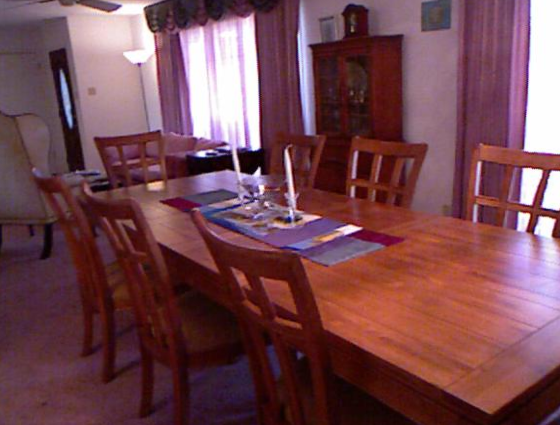

Question:	 what is at the right bottom
Answer:		 table (Label: 483)
Predicted Answer:	 table


In [31]:
showExample(train=False, id=1)
print("Predicted Answer:\t", answer_space[preds[i-2000]])

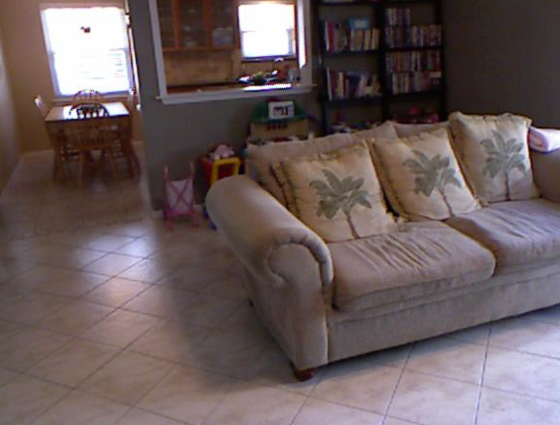

Question:	 what is the colour of pillows on the sofa
Answer:		 white, green (Label: 564)
Predicted Answer:	 white


In [33]:
showExample(train=False, id=2004)
print("Predicted Answer:\t", answer_space[preds[i-2000]])

## Inspecting Model Size

In [23]:
def countTrainableParameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of trainable parameters:\t{0:,}".format(num_params))

In [24]:
countTrainableParameters(model) # For BERT-ViT model

No. of trainable parameters:	196,956,998


In [36]:
path = os.path.join("..", "checkpoint", "bert_vit", "checkpoint-1500", "pytorch_model.bin")
path

'../checkpoint/bert_vit/checkpoint-1500/pytorch_model.bin'

In [41]:
!readlink -f ../checkpoint/bert_vit/checkpoint-1500/pytorch_model.bin

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/kaggle/checkpoint/bert_vit/checkpoint-1500/pytorch_model.bin


In [44]:
from IPython.display import FileLink
FileLink('/kaggle/checkpoint/bert_vit/checkpoint-1500/pytorch_model.bin')

/kaggle/checkpoint/bert_vit/checkpoint-1500/pytorch_model.bin

In [53]:
!tar -cvf vqa_model.tgz /kaggle/checkpoint/bert_vit/checkpoint-1500/pytorch_model.bin

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
tar: Removing leading `/' from member names
/kaggle/checkpoint/bert_vit/checkpoint-1500/pytorch_model.bin


In [54]:
ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint/  vqa_model.tgz  wandb/


In [56]:
!curl --upload-file vqa_model.tgz https://transfer.sh/vqa_model_jan4.tgz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
curl: (7) Failed to connect to transfer.sh port 443: Connection timed out
